In [3]:
from typing import TypedDict, Annotated, Union, Sequence, List, Any, Optional, Dict, Literal
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from load_model import load_model
import json
import operator
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableConfig, RunnableLambda
from pydantic import BaseModel, Field
import logging
import asyncio
from langgraph.types import interrupt, Command
from langchain_core.prompts import ChatPromptTemplate

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("agent_graph")


class Prediction(BaseModel):
    """
    Represents the agent's predicted action and its arguments.
    """
    action: str = Field(description="The action to be performed by the agent")
    args: List[str] = Field(default_factory=list, description="Arguments for the action")


class OldState(BaseModel):
    """
    Represents the state of the agent during execution.
    """
    testing: bool = Field(default=False, description="Flag indicating if the agent is in testing mode")
    test_actions: Optional[List[Prediction]] = Field(default_factory=list, description="The action to be tested")
    prediction: Optional[Prediction] = Field(None, description="The agent's predicted action and arguments")
    repeated_failures: Optional[int] = Field(default=0, description="Count of repeated failures for the current action")
    human_in_the_loop: bool = False
    DEBUG: bool = True


class AgentState(OldState):
    """State of the agent."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    agent_outcome: Union[AgentAction, AgentFinish, None] = None
    return_direct: bool = False
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add] = Field(default_factory=list)
    model_name: str = "gpt-4.1"  # Default model name
    test_responses: Optional[List[Dict[str, Any]]] = None  # Predefined responses for testing
    prompt_template: Optional[ChatPromptTemplate] = None  # Added prompt template field
    interrupt_response: Optional[str] = None  # Added interrupt response field
    
    class Config:
        arbitrary_types_allowed = True
        # Add this to handle serialization more gracefully
        json_encoders = {
            ChatPromptTemplate: lambda v: None if v is None else str(type(v).__name__),
            BaseMessage: lambda v: None if v is None else str(type(v).__name__),
        }


def create_agent_graph(tools, checkpointer=None):
    """Create an async LangGraph REACT agent with customizable prompts and testing capabilities.
    
    Args:
        tools: List of available tools
        checkpointer: Optional checkpointer for state persistence
        
    Returns:
        Compiled async StateGraph for the agent
    """
    logger.info(f"Creating agent graph with {len(tools)} tools")

    @RunnableLambda
    async def call_model(state: AgentState, config: RunnableConfig):
        """Call the LLM with the current conversation state."""
        logger.info(f"Calling model {state.model_name} with {len(state.messages)} messages")
        
        llm = load_model(
            model_name=state.model_name, 
            tools=tools, 
            )
            
        response = await llm.ainvoke(input=state.messages, config=config)
        # Return updated state with the response
        return {"messages": [response]}
    
    @RunnableLambda
    async def human_input(state: AgentState, config: RunnableConfig) -> Union[AgentState, dict]:
        # Extract the tool call details
        last_message = state.messages[-1]
        tool_call = last_message.tool_calls[0]
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        # Interrupt the graph and wait for human input
        message = f"Agent wants to perform: {tool_name} with args: {tool_args}"
        user_input = interrupt(message)
        
        # Different routing based on user input
        if not user_input or user_input.strip().lower() == "approved":
            # User approved - continue with tool execution
            return Command(goto="tools")
        
        elif user_input.strip().lower() == "exit":
            # User wants to stop execution
            return Command(goto=END)
        
        elif user_input.strip().lower() in ["no", "cancel", "reject"]:
            # User rejected - send back to agent with request for alternative
            return Command(
                goto="agent", 
                update={"messages": state.messages + [
                    HumanMessage(content="Please suggest an alternative approach.")
                ]}
            )
        
        else:
            # User provided custom instructions - send to agent with those instructions
            return Command(
                goto="agent",
                update={"messages": state.messages + [
                    HumanMessage(content=user_input)
                ]}
            )

    @RunnableLambda
    async def process_tool_execution(state: AgentState):
        """Execute tools and track intermediate steps."""
        # Get the last message with tool calls
        last_message = state.messages[-1]
        if not (isinstance(last_message, AIMessage) and last_message.tool_calls):
            return state

        tool_call = last_message.tool_calls[0]
        tool_name = tool_call["name"]
        tool_input = tool_call["args"]
        
        # Log the tool execution
        logger.info(f"Executing tool: {tool_name} with input: {json.dumps(tool_input)[:100]}...")
        
        # Create tool node for this execution
        tool_node = ToolNode(
            tools=tools,
            handle_tool_errors=lambda exception, tool_call: (
                f"Error executing tool {tool_call.get('name')}: {str(exception)}"
            ),
        )
        tool_names = [tool.name for tool in tools]
        if tool_name not in tool_names:
            raise ValueError(f"Tool {tool_name} not found in available tools: {tool_names}")
        result = await tool_node.ainvoke(state)
        
        # Create the agent action record
        agent_action = AgentAction(
            tool=tool_name,
            tool_input=tool_input,
            log=last_message.content
        )
        
        # Get the tool message content
        tool_message = result["messages"][-1]
        print(f"Tool message content: {tool_message}")
        
        # Add to intermediate steps
        new_steps = state.intermediate_steps + [(agent_action, tool_message.content)]
        
        logger.info(f"New intermediate steps: {len(new_steps)}")
        
        # Return updated state
        return {
            "messages": result["messages"],
            "intermediate_steps": new_steps
        }


    # Create the state graph
    workflow = StateGraph(AgentState)
    logger.info("Initializing state graph")
    
    # Add nodes
    workflow.add_node("agent", call_model)
    workflow.add_node("tools", process_tool_execution)
    workflow.add_node("human_input_node", human_input, destinations=("agent", "tools", END))
    
    # Set entry point
    workflow.set_entry_point("agent")
    
    # Define conditional edge routing
    def should_continue(state: AgentState) -> str:
        """Determine if we should continue with tools or end the conversation."""
        last_message = state.messages[-1]
        
        if state.human_in_the_loop and isinstance(last_message, AIMessage) and last_message.tool_calls:
            logger.info("Decision: Human intervention required")
            return "human_input_node"
        
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            logger.info("Decision: Agent requested tool execution")
            return "tools"
        else:
            logger.info("Decision: Agent completed task, ending workflow")
            return "end"
    
    # Connect nodes
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "tools": "tools",
            "end": END,
            "human_input_node": "human_input_node"
        }
    )
    workflow.add_edge("tools", "agent")

    logger.info("Graph structure defined and edges connected")
    
    # Compile the graph
    if checkpointer:
        logger.info("Compiling graph with checkpointer")
        return workflow.compile(checkpointer=checkpointer)
    
    logger.info("Compiling graph without checkpointer")
    return workflow.compile()

INFO:agent_graph:Creating agent graph with 0 tools
INFO:agent_graph:Initializing state graph
INFO:agent_graph:Graph structure defined and edges connected
INFO:agent_graph:Compiling graph with checkpointer


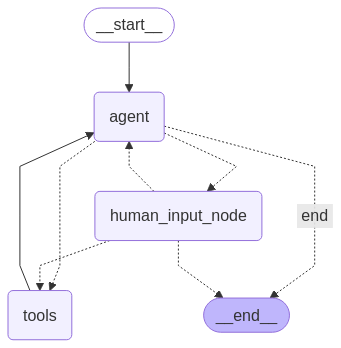

In [4]:
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

graph = create_agent_graph(tools=[], checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from typing import List, Dict, Any, Optional # Added Any, Optional
import os
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage
from langchain_mcp_tools import convert_mcp_to_langchain_tools
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
import logging # Add logging import

load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ConfigLLM(BaseModel):
    model_name: str = os.getenv("LLM_MODEL_NAME", "gpt-4.1-nano")
    temperature: float = 0.0

class MCPAgent:
    def __init__(self):
        self.llm = ConfigLLM()
        
        self.mcp_servers = {
                "playwright": {
                "command": "npx",  # Use resolved npx path
                "args": [
                    "@playwright/mcp@latest",
                    "--browser", "chrome"  # Options: chrome, firefox, webkit, msedge
                ],
                }
            }
        self.tools = None
        self.cleanup_func = None
        self.config = {"configurable": {"thread_id": "42"}}
        self.graph = None
        self.checkpointer = MemorySaver()
        self.reasoning_agent = False
        self.initialized = False
        self.human_in_the_loop = False
        
        # Add default system prompt
        self.default_system_prompt = "You are a helpful browser assistant. Use the browser tools to help the user."
        # Initialize prompt template with default
        self.prompt_template = self.create_default_prompt_template()
    
    
    def create_default_prompt_template(self):
        """Create a default prompt template that takes a query parameter"""
        from langchain_core.prompts import ChatPromptTemplate
        
        template = ChatPromptTemplate.from_messages([
            ("system", self.default_system_prompt),
            ("human", "{query}")
        ])
        return template
        
    def set_prompt_template(self, template: ChatPromptTemplate):
        """Set a custom prompt template for the agent."""
        self.prompt_template = template
        logger.info("Custom prompt template set for agent")
        
    async def set_agent_type(self, reasoning: bool = False):
        """Set the agent type and reinitialize the graph if needed"""
        if self.reasoning_agent == reasoning and self.initialized:
            # No change needed
            logger.info(f"Agent already set to {'reasoning' if reasoning else 'standard'} type")
            return
            
        logger.info(f"Changing agent type from {'reasoning' if self.reasoning_agent else 'standard'} to {'reasoning' if reasoning else 'standard'}")
        self.reasoning_agent = reasoning
        
        # Only rebuild graph if we've already initialized
        if self.initialized and self.tools:
            logger.info(f"Rebuilding graph for {'reasoning' if reasoning else 'standard'} agent")
            
            self.graph = create_agent_graph(
                    self.tools,
                    self.checkpointer
                )
            return True
        return False

    async def initialize(self):
        self.tools, self.cleanup_func = await convert_mcp_to_langchain_tools(self.mcp_servers)
        
        if self.tools:
            print("MCP tools loaded successfully")
            self.initialized = True  # Set flag to True after successful initialization
            self.graph = create_agent_graph(
                    self.tools,
                    self.checkpointer
                )
        else:
            raise Exception("No tools were loaded from MCP servers")
        
    async def astream_events(self, input):
        """Stream events from the agent with flexible input handling.
        
        Args:
            input: Either a string query or a list of BaseMessages
            config: Optional configuration dictionary (defaults to self.config)
        
        Yields:
            Events from the agent execution
        """
        if not self.initialized:
            await self.initialize()
        
        # Handle string query by formatting with prompt template
        if isinstance(input, str):
            logger.info("Formatting query using prompt template")
            messages = self.prompt_template.format_messages(query=input)
        else:
            # Assume input is already a list of messages
            logger.info("Using provided message list")
            messages = input
            
        # Create the initial state
        initial_state = AgentState(
            messages=messages,
            model_name=self.llm.model_name,
            human_in_the_loop=self.human_in_the_loop,
            testing=False,
            test_actions=[],
            return_direct=False,
            intermediate_steps=[],
            DEBUG=True,
            prompt_template=self.prompt_template  # Pass prompt template to state
        )
        
        print(f"Using {'reasoning' if self.reasoning_agent else 'standard'} agent graph")
        
        # Stream events from the graph
        async for event in self.graph.astream_events(
            initial_state,
            config=self.config,
            stream_mode="values"
        ):
            if event["event"] == "on_chat_model_stream":
                chunk = event["data"]["chunk"]
                chunk.content = await self.format_response(chunk.content)
                yield event

    async def format_response(self, content: str) -> str:
        """Format the response content. Can be overridden for custom formatting."""
        return content
        
    async def cleanup(self):
        """Clean up MCP servers and other resources."""
        if self.cleanup_func:
            try:
                await self.cleanup_func()
                print("MCP tools cleanup completed successfully")
            except Exception as e:
                print(f"Error during MCP tools cleanup: {e}")
        else:
            print("No cleanup function available")
        # Reset initialized state
        self.initialized = False

In [44]:
# Add a new cell to your notebook with this code
from langchain_core.messages import SystemMessage, HumanMessage

async def run_agent(query: str, human_in_the_loop: bool = False):
    # Create the agent
    agent = MCPAgent()
    
    # Set human-in-the-loop mode
    agent.human_in_the_loop = human_in_the_loop
    
    # Initialize the agent (loads tools)
    await agent.initialize()
    
    # Create input messages
    system_message = SystemMessage(content="You are a helpful browser assistant. Use the browser tools to help the user.")
    human_message = HumanMessage(content=query)
    messages = [system_message, human_message]
    
    # Stream events from the agent
    print(f"Running agent with query: {query} (Human-in-the-loop: {human_in_the_loop})")
    async for event in agent.astream_events(messages):
        if event["event"] == "on_chat_model_stream":
            chunk = event["data"]["chunk"]
            print(chunk.content, end="", flush=True)
    
    # Clean up when done
    await agent.cleanup()

# Run the agent with human-in-the-loop enabled
task = "Go to bing.com and search for 'python programming language'"
await run_agent(task, human_in_the_loop=True)

INFO:langchain_mcp_tools.langchain_mcp_tools:MCP server "mcpServers": initializing with: {'playwright': {'command': 'npx', 'args': ['@playwright/mcp@latest', '--browser', 'chrome']}}
ERROR:langchain_mcp_tools.langchain_mcp_tools:Error spawning MCP server: [Errno 13] Permission denied: ''


PermissionError: [Errno 13] Permission denied: ''